# Michaelis-Menten kinetics dynamics

### The Michaelis-Menten kinetics is given by the following system of (coupled) ordinary differential equations (ODEs):

$$
\dot{x}^{(\nu)}_i = -x^{(\nu)}_i + \sum_j w_{i,j} \cdot \frac{x^{(\nu)}_j}{1 + x^{(\nu)}_j}, \quad i, j \in \{1, \dots, N\}
$$

# TODOs
- create many cohorts with uniform p such that every cohort has a different p but an identical "base model" weight matrix (p $\in$ [0.05, 0.1, 0.15, ..., 1]) ✅
- run "negative spearman correlation" (it's a measure, just like Euclidean distance) on the results ✅
- Dimensionality reduction (PCA) - look for libraries that can perform dimensionality reduction. assert a "cloud like" distribution
- "Colonial expansion" - Make the defects uneven (e.g. base_model W $->$ 10 Ws with p = 0.2 and 40 Ws with p = 0.8)
- "Colonial expansion" should decrease GCL (higher p $->$ lower GCL)

In [460]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint  # Import the odeint function from scipy for solving ODEs # TODO I think solve_ivp is better
from scipy.integrate import solve_ivp  # Import the solve_ivp function from scipy for solving ODEs
from scipy.stats import spearmanr
import random

In [461]:
# Set up the system of ODEs
def ode_system(x, t, W):  # t must be passed even if not used
    N = len(x)  # Get the number of elements in the state vector
    derivative_vector = np.zeros(N)  # Initialize the derivative vector (set zeros as default)
    for i in range(N):  # Loop over each element in the state vector
        # Compute the sum term for the i-th element according to the formula given in the paper
        sum_term = sum(W[i, j] * (x[j] / (1 + x[j])) for j in range(N) if j != i)  # list comprehension
        derivative_vector[i] = -x[i] + sum_term
    return derivative_vector

In [462]:
# Initialize parameters
N = 100#100#50  #100  # Number of genes in a cell
M = 30#25 #25  #50  # Number of "defects" of the matrix W
avg_deg = 3

initial_conditions = [np.random.rand(N) for _ in range(N)]

dist = lambda x: random.random() < x
q = 1  # Affects the range of the random numbers generated
probability_spacing = 0.1  #0.05
num_of_cohorts = int(1 / probability_spacing) + 1
p = np.linspace(0, 1, num_of_cohorts) # probability to create a defect
W = [[np.zeros((N, N)) for _ in range(M)] for __ in range(
    num_of_cohorts)]  # Initialize the weight matrix with zeros; W[cohort index][defect index][(row, column)] TODO: Perhaps there is a simpler more elegant way to do this with smaller dimension arrays.

num_of_time_stamps = 1000
t_final = 20
t = np.linspace(0, t_final, num_of_time_stamps)

# TODO: Figure out how to make the odeint function stop when the system reaches a steady state or after a certain time period

In [463]:
print(p)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [464]:
print(len(W))  # len(p) = num_of_cohorts = 21 W is an array that each element represents a cohort with different p
print(len(W[0]))  # M = 50 an element in W is an array of 50 weight matrices
print(len(W[0][0][0]))  # N = 100 num of genes each weight matrix is an NxN matrix
print(len(W[0][0][1]))  # N = 100 num of genes each weight matrix is an NxN matrix

11
30
100
100


In [465]:
for cohort_index in range(num_of_cohorts):
    # for each cohort, create a system of 50 w defect matrices

    # Set the base weight matrix for the current cohort
    # TODO: this is weird since I defined avg_deg as the average degree but I use it as a probability distribution (actual average might be different) maybe change that in the future
    base_model = np.array([[np.random.uniform(0, 2 * q) if (row != column and dist(avg_deg / (N - 1))) else 0
                            for column in range(N)] for row in range(N)])

    # TODO: the first iteration is useless since p[0] = 0 by definition and its a simple copy of base_model. Maybe change that in the future
    # Create defects of the weight matrix
    # TODO: Too many indentations, maybe refactor this code
    for defect_index in range(M):
        for row in range(N):
            for column in range(N):
                if base_model[row, column] != 0:
                    if dist(p[cohort_index]):
                        # TODO: What if, by chance np.random.uniform(0, 2 * q) is the same as base_model[row, column] or if it is 0? these are edge cases that are rare and therefore not handled
                        W[cohort_index][defect_index][row, column] = np.random.uniform(0, 2 * q)
                    else:
                        W[cohort_index][defect_index][row, column] = base_model[row, column]
                else:
                    W[cohort_index][defect_index][row, column] = 0

# TODO use solve_ivp instead of ode_int !!!

https://stackoverflow.com/questions/33072604/how-to-get-scipy-integrate-odeint-to-stop-when-path-is-closed
https://stackoverflow.com/questions/63453965/scipy-solve-ivp-terminate-trajectory-on-second-occurrence-of-event
https://github.com/scipy/scipy/issues/14176


https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.set_solout.html

In [466]:
# This block takes too long to run :(
# Initialize the results array
# results[cohort index][defect index][(row, column)] - rows represents timestamps, columns represent gene index
results = [[np.zeros((num_of_time_stamps, N)) for _ in range(M)] for __ in range(num_of_cohorts)]

# Define a wrapper for solve_ivp
def ode_system_ivp(t, x, W):
    return ode_system(x, t, W)  # You might need to adjust if ode_system expects t first


# Solve the ODEs for all M weight matrix and corresponding initial conditions
for cohort_index in range(num_of_cohorts):
    for defect_index in range(M):
        results[cohort_index][defect_index] = solve_ivp(ode_system_ivp, [t[0], t[-1]], initial_conditions[defect_index], args=(W[cohort_index][defect_index], ), t_eval=t).y.T
        # odeint will return a vector (function) where the rows represent discrete time frames and the columns represent the values of x_i so this vector is x_i(t)

        # results[cohort_index][defect_index] = odeint(ode_system, initial_conditions[defect_index], t,
        #                                              args=(W[cohort_index][defect_index],))

In [467]:
## just testing things here
results0 = results[0][0][-1][
           :]  # list of genes in a single cell (first group of cohorts, first cell, -1 means steadystate time, : means get all the genes in this cell
results0
results1 = results[0][1][-1][:]  # (first group of cohorts, second cell, steady state time, and all the genes)
results2 = results[0][2][-1][:]
# ......
resultsMc = results[num_of_cohorts - 1][M - 1][-1][:]

In [468]:
transposed_steady_state = [np.zeros((M, N)) for _ in range(num_of_cohorts)]
for cohort_j in range(num_of_cohorts):
    cur_co = results[cohort_j]
    for cell_index in range(M):
        cur_cell = cur_co[cell_index]
        transposed_steady_state[cohort_j][cell_index] = (cur_cell[-1])
actual_steady_state = [np.transpose(transposed_steady_state[i]) for i in range(num_of_cohorts)]
actual_steady_state[0]

array([[1.23696461, 1.23696773, 1.23696845, ..., 1.23696831, 1.236969  ,
        1.23696721],
       [4.74709199, 4.74710574, 4.74711167, ..., 4.74710162, 4.74711467,
        4.74709816],
       [2.71371408, 2.71372061, 2.71372175, ..., 2.71371984, 2.7137217 ,
        2.71371513],
       ...,
       [1.29131151, 1.29131625, 1.29131776, ..., 1.29131523, 1.29131802,
        1.29131458],
       [1.27611084, 1.27611696, 1.27611838, ..., 1.27611493, 1.27611972,
        1.27611486],
       [1.00850429, 1.00851006, 1.00851203, ..., 1.0085076 , 1.00851171,
        1.00850667]])

### Calculate ~~Negative~~ Spearman Correlation

In [469]:
spearman_steady_state = [spearmanr(actual_steady_state[i])[0] for i in range(len(actual_steady_state))]

In [470]:
print(np.shape(spearman_steady_state))
spearman_steady_state[0]
spearmanr(actual_steady_state[2])[0]  # [0] gives the Spearman correlation matrix, [1] will give the p value

(spearmanr(actual_steady_state[0])[0])
len(spearmanr(actual_steady_state[0])[0])


(11, 30, 30)


30

In [471]:
# get the off diagonal elements and graph a distribution of them:
off_diagonal_elements = [[] for _ in range(len(spearman_steady_state))]

for mnm in range(len(spearman_steady_state)):
    for row_index in range(len(spearmanr(actual_steady_state[0])[0])):
        for column_index in range(len(spearmanr(actual_steady_state[0])[0])):
            if column_index > row_index:
                off_diagonal_elements[mnm].append(spearman_steady_state[mnm][row_index][column_index])

off_diagonal_elements = [np.round(element, decimals=3) for element in off_diagonal_elements]

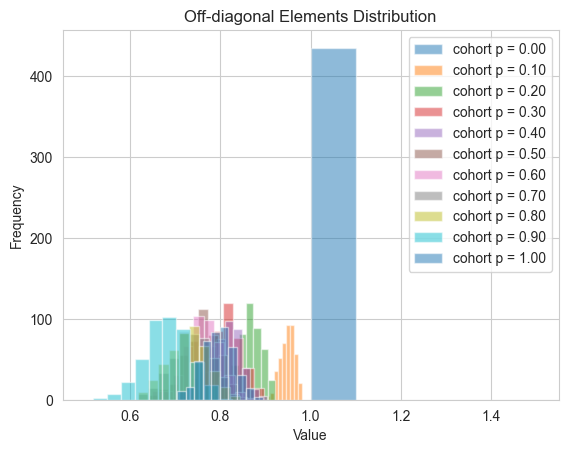

In [472]:
# Plot the off-diagonal elements distribution
for sss in range(len(off_diagonal_elements)):
    plt.hist(off_diagonal_elements[sss], alpha=0.5, label='cohort p = {:.2f}'.format(p[sss]))

# plt.xlim(-0.0001, 0.000005)

# Add title and labels
plt.title('Off-diagonal Elements Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [473]:
# Use dimensionality reduction to reduce the spearman matrix by using PCA

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare the data
# spearman_steady_state is a list of Spearman correlation matrices (matrix for each cohort)
# Flatten the Spearman correlation matrices for PCA (e.g. [[1,2], [3,4]] --> [[1, 2, 3, 4]])
# I think I can use instead * when creating spearman but whatever
flattened_spearman = [matrix.flatten() for matrix in spearman_steady_state]

# Scale the data - this will take care of the normalization step I mentioned above 
scaler = StandardScaler()
standardized_data = scaler.fit_transform(flattened_spearman)

# Apply PCA - project the components to the two PCi's with the highest variation
pca = PCA(n_components=2)  # You can change the number of components as needed
pca_result = pca.fit_transform(standardized_data)

# [variance of PC1, variance of PC2]
print("Variance ratio:", pca.explained_variance_ratio_)

# Print the PCA result [PC1, PC2]
print("PCA result:\n", pca_result)

Variance ratio: [0.89230721 0.02199859]
PCA result:
 [[ 58.399622    -0.48323644]
 [ 42.50777451  -1.40099782]
 [ 17.72231728  -0.18890723]
 [ -0.26583742  -2.93046291]
 [  0.82035298  -0.22538199]
 [-15.60493365   2.32657266]
 [-14.67913899  -0.1073862 ]
 [-21.83648653   6.57664819]
 [-24.67144556   5.48511271]
 [-37.99008831 -10.84752421]
 [ -4.40213631   1.79556323]]


Explained variance ratio: [0.89230721 0.02199859]
PCA result:
 [[ 58.399622    -0.48323644]
 [ 42.50777451  -1.40099782]
 [ 17.72231728  -0.18890723]
 [ -0.26583742  -2.93046291]
 [  0.82035298  -0.22538199]
 [-15.60493365   2.32657266]
 [-14.67913899  -0.1073862 ]
 [-21.83648653   6.57664819]
 [-24.67144556   5.48511271]
 [-37.99008831 -10.84752421]
 [ -4.40213631   1.79556323]]


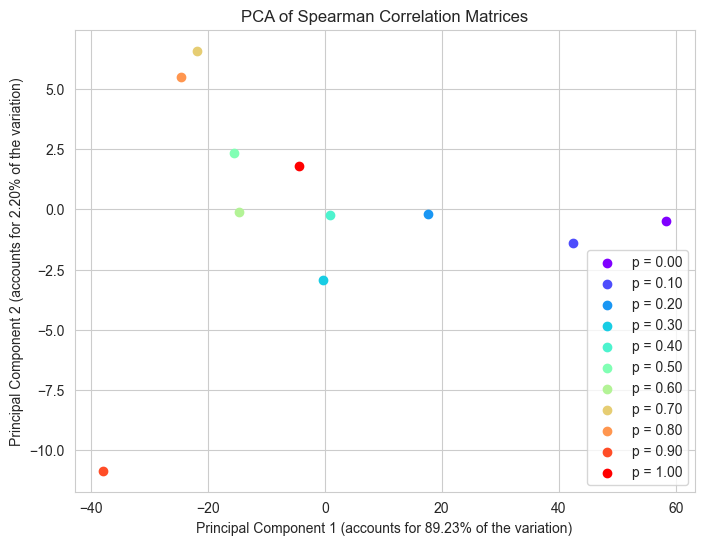

In [474]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming spearman_steady_state is a list of Spearman correlation matrices
# Flatten the Spearman correlation matrices to 2D arrays for PCA
flattened_spearman = [matrix.flatten() for matrix in spearman_steady_state]

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(flattened_spearman)

# Apply PCA
pca = PCA(n_components=2)  # You can change the number of components as needed
pca_result = pca.fit_transform(standardized_data)

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Print the PCA result
print("PCA result:\n", pca_result)

# Plot the PCA results with different colors for each point
plt.figure(figsize=(8, 6))
colors = cm.rainbow(np.linspace(0, 1, len(p)))
for i in range(len(p)):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], color=colors[i], label=f'p = {p[i]:.2f}')

plt.title('PCA of Spearman Correlation Matrices')
plt.xlabel('Principal Component 1 (accounts for {:.2f}% of the variation)'.format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel('Principal Component 2 (accounts for {:.2f}% of the variation)'.format(pca.explained_variance_ratio_[1] * 100))
plt.legend()
plt.grid(True)
plt.show()

#### PCA
check out this video: https://youtu.be/FgakZw6K1QQ

##### PC1
- Calculate the average measurement for gene 1, 2, 3, ..., N - get the "center" of the data
- Recalculate the data relative to center (the center is the origin).
- Find the best fit linear line that passes through the origin for the data by choosing the line that maximizes the sum of the distances of the points projected by each one of the points on to the line - this line is PC1.
- Normalize the line to unit length it is the eigen vector (also called singular vector) of PC1. the proportion of each gene are called "loading scores" (kind of like tan(theta) = y/x in 2d). The average of the sum of squared distances (of the points projected on to the PC1 line) is the eigen value for PC1. The square root of the sum of the squared distances is called the singular value for PC1

##### PC2
- The line that is perpendicular to PC1 (m_pc1 * m_pc2 = -1 for 2d, the number of PC's will be the MIN(variables (genes), samples(cells))) This line is the eigen vector for PC2. The loading scores are the projection of the normalized line on to the gene1 axis (x) and the projection of the normalized line on to the gene2 axis (y). The average of the sum of squared distances (of the points projected on to the PC2 line) is the eigen value for PC2.

PC1 accounts for eigen_value_pc1/(eigen_value_pc1 + eigen_value_pc2) of the total variation
PC2 accounts for eigen_value_pc2 / (eigen_value_pc1 + eigen_value_pc2) of the total variation

We may have many PCi's, but after we calculated the principal components we simply project them to the 2 most dominant pc's (the ones with the highest eigen value i.e. highest variation) NOTE: this will only be good if they account for most of the variation.
Use a scree plot for the PCi's

In [475]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

In [476]:
# results[cohort_index][defect_index][final_time=-1, :]
results[0][0]  #first cohort(p=0), first set of M(=50) w's - it is a vector where rows = time and columns = values; I want the last row:
steady_state_test = results[0][0][-1]
steady_state_test
steady_state = np.zeros((num_of_cohorts, N))

# for cohort_i in range(num_of_cohorts):
#     for defects_group_i in range(M):
#         steady_state[]
steady_state
# steady_state = [results[cohort_i][:][-1] for cohort_i in range(num_of_cohorts)] for gene in range(N)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

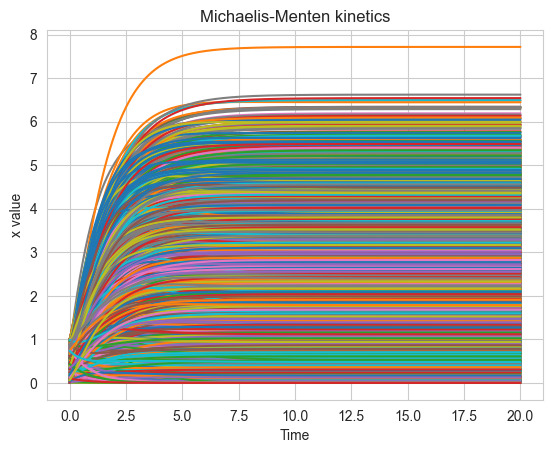

In [477]:
# Plot the results
for cohort_index in range(num_of_cohorts):
    for defect_index in range(M):
        for gene in range(N):
            plt.plot(t, results[cohort_index][defect_index][:, gene])
plt.xlabel('Time')
plt.ylabel('x value')
plt.title('Michaelis-Menten kinetics')
plt.show()

# ---------

In [478]:
# initial state
results[0][0, :]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
final_state = [np.random.rand(N) for _ in range(N)]
# final state
for m in range(M):
    final_state[m] = results[m][-1, :]

In [ ]:
# Calculate the variance of the final state
final_state_variance = np.var(final_state)
print(final_state_variance)

In [ ]:
# W2_variance = np.var(W_strong_influence)
# print(W_strong_influence)

In [ ]:
# Save the final state vector to a csv file
# np.savetxt('final_state.csv', final_state, delimiter=',')